# <center> ACML Project- Sentiment Analysis of Twitter Data using Naive Bayes and Support Vector Machine </center>
## <center> Rylan Perumal - 1396469 </center>
## <center> School of Computer Science and Applied Mathematics </center>
<img src="../images/wits_logo.png" alt="drawing" width="300"/>

***

# Naive Bayes Implementation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import re
import math
import random as rand
from collections import Counter
from itertools import chain
import nltk
from sklearn.model_selection import train_test_split

## Feature Extraction
- Class 1 refers to positive sentiment
- Class 2 refers to negative sentiment

In [2]:
# reading in the pre-processed data
tweets = pd.read_csv('data/tweets_pre_processed_clean.csv')

In [3]:
tweets.head()

,text,tweet_no_punc,tweet_english,tweet_token,tweet,lang,class
0,Big ol freak just make you wann twerk 😂,Big ol freak just make you wann twerk,Big freak just make you,"['big', 'freak', 'just', 'make', 'you']","['big', 'freak', 'make']",en,1.0
1,The rain thought it was slick 😂 i got my umbre...,The rain thought it was slick i got my umbrell...,The rain thought it was slick i got my umbrell...,"['the', 'rain', 'thought', 'it', 'was', 'slick...","['rain', 'thought', 'slick', 'got', 'umbrella'...",en,1.0
2,RT @noahcent: I crack myself up dude 😂\n\nhttp...,I crack myself up dude,I crack myself up dude,"['i', 'crack', 'myself', 'up', 'dude']","['crack', 'dude']",en,1.0
3,BC I was feeling tf outta myself. 😌,BC I was feeling tf outta myself,I was feeling myself,"['i', 'was', 'feeling', 'myself']",['feeling'],en,1.0
4,RT @NBCSPhilly: Feeling ready to pop off. Lite...,Feeling ready to pop off Literally Joel Embiid...,Feeling ready to pop off Literally is really o...,"['feeling', 'ready', 'to', 'pop', 'off', 'lite...","['feeling', 'ready', 'pop', 'literally', 'real...",en,1.0


In [4]:
def train_test(data):
    train_data, test_data = train_test_split(data, test_size=0.2)
    return test_data, train_data, data

In [5]:
def tokenize_string(text):
    text = str(text)
    text = text[1:]
    text = re.sub("]", "", text)
    text = re.sub("'", "", text)
    tokens = re.split(",", text)
    return tokens

In [6]:
def feature_extraction(dataset):
    # extracting positive and negative review
    positive = dataset.tweet_token[dataset['class'] == 1]    
    negative = dataset.tweet_token[dataset['class'] == 0]
    
    positive_token = positive.apply(lambda x: tokenize_string(x))
    negative_token = negative.apply(lambda x: tokenize_string(x))

    # creating positive and negative word lists
    positive_words = []
    negative_words = []
    for i in range(len(positive_token)):
        array = positive_token.iloc[i]
        array = list(set(array))
        for j in range(len(array)):
            array[j] = array[j].replace(" ", "")
        
        positive_words.extend(list(set(array)))
    for i in range(len(negative_token)):
        array = negative_token.iloc[i]
        array = list(set(array))
        for j in range(len(array)):
            array[j] = array[j].replace(" ", "")
        
        negative_words.extend(list(set(array)))
    
    # removing whitespace that comes from tokenization
    while('' in positive_words):
        positive_words.remove('')
    while('' in negative_words):
        negative_words.remove('')
    # extracting the uncommon words
    unique_neg = list(set(negative_words) - set(positive_words)) # negative words not in positive words
    unique_pos = list(set(positive_words) - set(negative_words)) # positive words not in negative words
    # normalisation and increasing likelyness of where uncommon word appears
#     positive_words.extend(unique_neg)
#     negative_words.extend(unique_pos)
    # building word dictionaries, feature extraction
    positive_dict = Counter(positive_words)
    negative_dict = Counter(negative_words)

    return positive_dict, negative_dict, positive_words, negative_words

In [7]:
def train(positive_dict, negative_dict, positive_words, negative_words):
    # training 
    for key in positive_dict:
        positive_dict[key] = positive_dict[key] / len(positive_words)
    for key in negative_dict:
        negative_dict[key] = negative_dict[key] / len(negative_words)
    return positive_dict, negative_dict

In [8]:
def naive_bayes(testset, positive_dict, negative_dict, prior_pos, prior_neg):
    # elements of confusion matrix
    pos_p = 0 # classified: positive, class: positive
    pos_n = 0 # classified: positive, class: negative
    neg_n = 0 # classified: negative, class: negative
    neg_p = 0 # classified: negative, class: positive
    
    # iterating through all of the test points
    test_token = testset.tweet_token.apply(lambda x: tokenize_string(x))
    for i in range(test_token.shape[0]):
        tweet = test_token.iloc[i] # a string containg the tweet
        for j in range(len(tweet)):
            tweet[j] = tweet[j].replace(" ", "")
        positive_probability = 1
        negative_probability = 1     
        for k in tweet:
            if k in positive_dict.keys():
                positive_probability *= positive_dict[k]
            else: # smoothing
                positive_probability *= 1 / len(positive_dict)
        for k in tweet:
            if k in negative_dict.keys():
                negative_probability *= negative_dict[k]
            else: # smoothing
                negative_probability *= 1 / len(negative_dict)
        normalisation = positive_probability*prior_pos + negative_probability*prior_neg
        posterior_positive = positive_probability*prior_pos/ normalisation
        posterior_negative = negative_probability*prior_neg/ normalisation
        
        if(posterior_positive > posterior_negative):
            # tweet has been classified as positive
            if(testset.iloc[i]['class'] == 1):
                pos_p += 1
            else:
                pos_n += 1
        elif(posterior_positive < posterior_negative):
            # tweet has been classified as negative            
            if(testset.iloc[i]['class'] == 0):
                neg_n += 1
            else:
                neg_p += 1
#         else:
#             print("Tweet: ", i, " -> could not classifiy")
    return pos_p, pos_n, neg_p, neg_n

In [13]:
def plot_confusion_matrix(pos_p, pos_n, neg_p, neg_n):
    cm = np.array([[pos_p, pos_n], [neg_p, neg_n]])
    fig, ax = plt.subplots()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
    plt.xlabel('Class')
    plt.ylabel('Prediction')
    target_names = ['Positive', 'Negative']
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=0)
    plt.yticks(tick_marks, target_names)
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    width, height = cm.shape
    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), horizontalalignment='center', verticalalignment='center')
    plt.savefig('../nb_confusion')

In [10]:
def run_multiple(tweets, runs=2, training=False, supressed_ouput=False):
    accuracy_array = []
    precision_t_array = []
    precision_n_array = []
    precision_array = []
    recall_array = []
    recall_array_t = []
    recall_array_n = []
    f1_score_array = []
    f1_score_array_t = []    
    f1_score_array_n = []
    for i in np.arange(1, runs):
        # shuffling the dataframe so that we do not get a biased training sample
        tweets = tweets.reindex(np.random.permutation(tweets.index))
        tweets.reset_index(drop=True)
        test_tweets, train_tweets, data = train_test(tweets)
        total_tweets = data.shape[0]
        # prior probability
        prior_pos = (data[data['class'] == 1]).shape[0] / total_tweets
        prior_neg = (data[data['class'] == 0]).shape[0] / total_tweets
        positive_dict, negative_dict, positive_words, negative_words = feature_extraction(train_tweets)
        positive_dict, negative_dict = train(positive_dict, negative_dict, positive_words, negative_words)
        if training:
             pos_p, pos_n, neg_p, neg_n = naive_bayes(train_tweets, positive_dict, negative_dict, prior_pos, prior_neg) 
        else:
            pos_p, pos_n, neg_p, neg_n = naive_bayes(test_tweets, positive_dict, negative_dict, prior_pos, prior_neg) 
        if supressed_ouput:
            plot_confusion_matrix(pos_p, pos_n, neg_p, neg_n)
        
        accuracy = (pos_p + neg_n) / (pos_p + pos_n + neg_n + neg_p)
        precision_t = pos_p / (pos_p + pos_n)
        precision_n = neg_n / (neg_n + neg_p)
        recall_t = pos_p / (pos_p + neg_p)
        recall_n = neg_n / (neg_n + pos_n)
        f1_score_t = 2*((precision_t*recall_t)/(precision_t + recall_t))
        f1_score_n = 2*((precision_n*recall_n)/(precision_n + recall_n))
        accuracy_array.append(accuracy)
        precision_t_array.append(precision_t)
        precision_n_array.append(precision_n)
        recall_array_t.append(recall_t)
        recall_array_n.append(recall_n)
        f1_score_array_t.append(f1_score_t)
        f1_score_array_n.append(f1_score_n)
    precision_array.append(precision_t_array)
    precision_array.append(precision_n_array)
    recall_array.append(recall_array_t)
    recall_array.append(recall_array_n)
    f1_score_array.append(f1_score_array_t)
    f1_score_array.append(f1_score_array_n)
    return accuracy_array, precision_array, recall_array, f1_score_array

Testing Accuracy = 68.98%
Testing Precision positive = 68.81%
Testing Precision negative = 69.12%
Testing Recall positive = 63.75%
Testing Recall negative = 73.74%
Testing F1 Score positive = 66.18%
Testing F1 Score negative = 71.35%


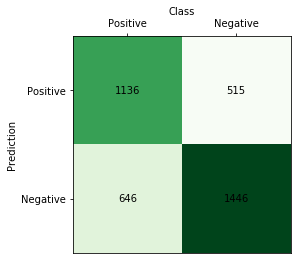

In [14]:
accuracy_array_train, precision_array_train, recall_array_train, f1_score_array_train = run_multiple(tweets, training=True)
accuracy_array_test, precision_array_test, recall_array_test, f1_score_array_test = run_multiple(tweets, supressed_ouput=True)

avg_accuracy_test = sum(accuracy_array_test) / len(accuracy_array_test)
avg_precision_test_t = sum(precision_array_test[0]) / len(precision_array_test[0])
avg_precision_test_n = sum(precision_array_test[1]) / len(precision_array_test[1])
avg_recall_test_t = sum(recall_array_test[0]) / len(recall_array_test[0])
avg_recall_test_n = sum(recall_array_test[1]) / len(recall_array_test[1])
avg_f1_score_test_t = sum(f1_score_array_test[0]) / len(f1_score_array_test[0])
avg_f1_score_test_n = sum(f1_score_array_test[1]) / len(f1_score_array_test[1])

avg_accuracy_train = sum(accuracy_array_train) / len(accuracy_array_train)
avg_precision_train_t = sum(precision_array_train[0]) / len(precision_array_train[0])
avg_precision_train_n = sum(precision_array_train[1]) / len(precision_array_train[1])
avg_recall_train_t = sum(recall_array_train[0]) / len(recall_array_train[0])
avg_recall_train_n = sum(recall_array_train[1]) / len(recall_array_train[1])
avg_f1_score_train_t = sum(f1_score_array_train[0]) / len(f1_score_array_train[0])
avg_f1_score_train_n = sum(f1_score_array_train[1]) / len(f1_score_array_train[1])

print('Testing Accuracy = {:>2.2f}%'.format(avg_accuracy_test*100))
print('Testing Precision positive = {:>2.2f}%'.format(avg_precision_test_t*100))
print('Testing Precision negative = {:>2.2f}%'.format(avg_precision_test_n*100))
print('Testing Recall positive = {:>2.2f}%'.format(avg_recall_test_t*100))
print('Testing Recall negative = {:>2.2f}%'.format(avg_recall_test_n*100))
print('Testing F1 Score positive = {:>2.2f}%'.format(avg_f1_score_test_t*100))
print('Testing F1 Score negative = {:>2.2f}%'.format(avg_f1_score_test_n*100))
print('-------------------------------------------------------------')
print('Training Accuracy = {:>2.2f}%'.format(avg_accuracy_train*100))
print('Training Precision positive = {:>2.2f}%'.format(avg_precision_train_t*100))
print('Training Precision negative = {:>2.2f}%'.format(avg_precision_train_n*100))
print('Training Recall positive = {:>2.2f}%'.format(avg_recall_train_t*100))
print('Training Recall negative = {:>2.2f}%'.format(avg_recall_train_n*100))
print('Training F1 Score positive = {:>2.2f}%'.format(avg_f1_score_train_t*100))
print('Training F1 Score negative = {:>2.2f}%'.format(avg_f1_score_train_n*100))